In [1]:
import sys

import numpy as np

from scipy import stats

from matplotlib import pyplot as plt

from enum import Enum, IntEnum, unique, auto

In [2]:

@unique
class Suit(Enum) :
    NONE     = auto()
    HEARTS   = auto()
    DIAMONDS = auto()
    SPADES   = auto()
    CLUBS    = auto()
    def __str__ (self) :
        if self == Suit.NONE :
            return "-"
        return self.name[0]

class CardNumber(IntEnum) :
    NONE  = 0
    TWO   = 2
    THREE = 3
    FOUR  = 4
    FIVE  = 5
    SIX   = 6
    SEVEN = 7
    EIGHT = 8
    NINE  = 9
    TEN   = 10
    ACE   = 11
    JACK  = 12
    QUEEN = 13
    KING  = 14
    def points(self) :
        if self.value > 11 : return 10
        return int(self)
    def __str__(self) :
        if self == CardNumber.JACK  : return "J"
        if self == CardNumber.QUEEN : return "Q"
        if self == CardNumber.KING  : return "K"
        if self == CardNumber.ACE   : return "A"
        return str(self.value)

class Card :
    def __init__(self, number=CardNumber.NONE, suit=Suit.NONE) :
        if type(number) is Suit and type(suit) is CardNumber :
            suit, number = number, suit
        self.suit     = suit
        self.number   = number
        self.used_ace = False
    def points(self) :
        if self.is_usable_ace()          : return 11
        if self.number == CardNumber.ACE : return 1
        return self.number.points()
    def is_usable_ace(self) :
        return ((self.number == CardNumber.ACE) and (self.used_ace == False))
    def use_ace(self) :
        self.used_ace = True
    def is_valid(self) :
        return self.number != CardNumber.NONE and self.suit != Suit.NONE
    def __str__(self) :
        return str(self.number) + str(self.suit)
    
class State :
    def __init__(self, points=0, available_ace=False, dealer_points=0) :
        self.points        = int(points)
        self.available_ace = available_ace
        self.dealer_points = int(dealer_points)
    def value(self) :
        if self.points == 0 :
            return 0
        return self.points + 100*self.dealer_points + 10000*self.available_ace
    def __str__(self) :
        return f"{self.points}PTS, {'NO ' if not self.available_ace else ''}ACE, DEALER {self.dealer_points}PTS"
    @classmethod
    def from_value(cls, value) :
        points        = value % 100
        dealer_points = ((value - points) % 10000) / 100
        available_ace = True if value > 9999 else False
        return cls(points, available_ace, dealer_points)
    
suits        = [s for s in Suit if s != Suit.NONE]
card_numbers = [n for n in CardNumber if n != CardNumber.NONE]


In [3]:
def deal(draw_deck, hand=[], min_pts=0) :
    hand.append(draw_deck.pop(np.random.choice(len(draw_deck), size=(1,))[0]))
    while np.sum([c.points() for c in hand]) < min_pts :
        hand.append(draw_deck.pop(np.random.choice(len(draw_deck))))
    return hand
        

In [43]:
num_toys = 1000000
alpha    = 0.1
values, values_true_MC, n_samples = {}, {}, {}

sys.stdout.write("Running toys: 0%")
for toy_idx in range(num_toys) :
    if 100*(toy_idx+1) % num_toys == 0 : sys.stdout.write(f"\rRunning toys: {100*int(toy_idx+1)/num_toys:.0f}%")
    
    draw_deck = list(np.array([[Card(s,n) for s in suits] for n in card_numbers]).flatten())
    dlr_hand      = []
    dlr_hand      = deal(draw_deck, dlr_hand, min_pts=12)
    dlr_points    = np.sum([c.points() for c in dlr_hand])
    dlr_has_ace   = True in [c.is_usable_ace() for c in dlr_hand]
    dlr_show_val  = dlr_hand[0].points()
    
    terminate_game = False
    while not terminate_game :
        if dlr_points < 17 :
            dlr_hand    = deal(draw_deck, dlr_hand)
            dlr_points += dlr_hand[-1].points()
            if dlr_points > 21 and dlr_has_ace :
                dlr_points -= 10
                card_idx, found_ace = 0, False
                while not found_ace :
                    card = dlr_hand[card_idx]
                    if card.is_usable_ace() :
                        card.use_ace()
                        found_ace = True
                    card_idx += 1
                dlr_has_ace = True in [c.is_usable_ace() for c in dlr_hand]
            if dlr_points > 21 :
                terminate_game = True
        else : 
            terminate_game = True
            
    my_hand   = []
    my_hand   = deal(draw_deck, my_hand, min_pts=12)
    my_points = np.sum([c.points() for c in my_hand])
    has_ace   = True in [c.is_usable_ace() for c in my_hand]
    
    states = [State(my_points, has_ace, dlr_show_val)]
    
    terminate_game = False
    while not terminate_game :
        if my_points < 17 :
            my_hand   = deal(draw_deck, my_hand)
            my_points += my_hand[-1].points()
            if my_points > 21 and has_ace :
                my_points -= 10
                card_idx, found_ace = 0, False
                while not found_ace :
                    card = my_hand[card_idx]
                    if card.is_usable_ace() :
                        card.use_ace()
                        found_ace = True
                    card_idx += 1
                has_ace = True in [c.is_usable_ace() for c in my_hand]
            if my_points > 21 :
                terminate_game = True
                reward         = -1
        else : 
            terminate_game = True
            if   my_points >  dlr_points : reward = 1
            elif my_points == dlr_points : reward = 0
            else                         : reward = -1
        if my_points < 22 :
            states.append(State(my_points, has_ace, dlr_show_val))
               
    for state in states :
        state_hash        = state.value()
        old_value         = values   .get(state_hash, 0)
        old_value_true_MC = values   .get(state_hash, 0)
        old_number        = n_samples.get(state_hash, 0)
        values_true_MC[state_hash] = (old_value_true_MC*old_number + reward) / (old_number+1)
        values        [state_hash] = old_value + alpha*(reward - old_value)
        n_samples     [state_hash] = old_number + 1
    

Running toys: 100%

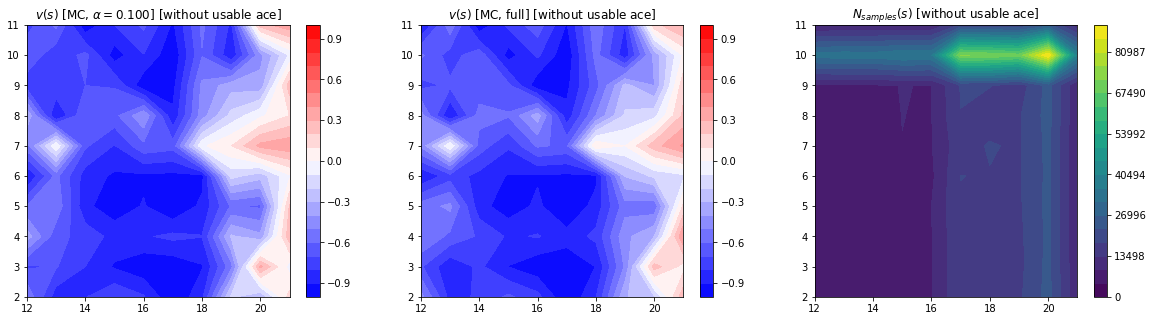

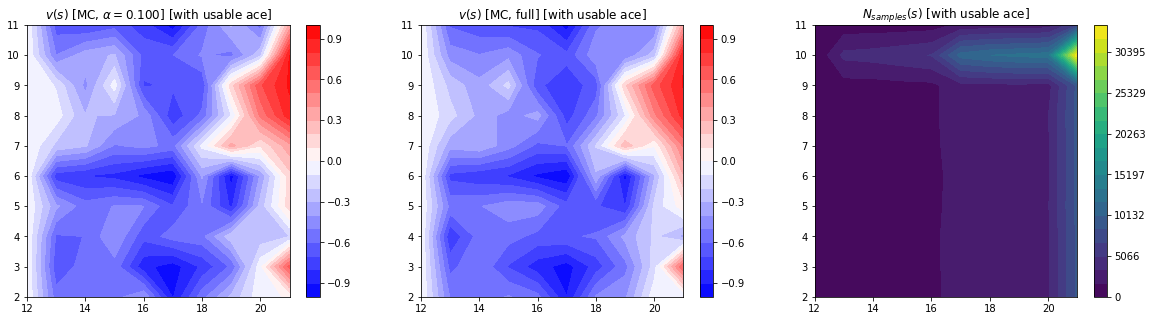

In [51]:

def plot_values(with_ace=False) :
    X = np.arange(12, 22)
    Y = np.arange(2, 12)
    X, Y = np.meshgrid(X, Y)

    Z1 = np.zeros(shape=(len(X), len(Y)))
    Z2 = np.zeros_like(Z1)
    Z3 = np.zeros_like(Z1)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z1[i,j] = values        .get(State(X[i,j], with_ace, Y[i,j]).value(), 0)
            Z2[i,j] = values_true_MC.get(State(X[i,j], with_ace, Y[i,j]).value(), 0)
            Z3[i,j] = n_samples     .get(State(X[i,j], with_ace, Y[i,j]).value(), 0)
    
    fig  = plt.figure(figsize=(20, 5))
    ax   = fig.add_subplot(1, 3, 1)
    cbar = ax.contourf(X, Y, Z1, cmap="bwr", levels=np.linspace(-1, 1, 21))
    title_suffix = " [with usable ace]" if with_ace else " [without usable ace]"
    ax.set_title(r"$v(s)$ [MC, $\alpha="+f"{alpha:.3f}$]"+title_suffix)
    plt.colorbar(cbar)
    ax   = fig.add_subplot(1, 3, 2)
    cbar = ax.contourf(X, Y, Z2, cmap="bwr", levels=np.linspace(-1, 1, 21))
    ax.set_title(r"$v(s)$ [MC, full]"+title_suffix)
    plt.colorbar(cbar)
    ax   = fig.add_subplot(1, 3, 3)
    cbar = ax.contourf(X, Y, Z3, levels=np.linspace(0, np.max(Z3), 21))
    ax.set_title(r"$N_{samples}(s)$"+title_suffix)
    plt.colorbar(cbar)
    plt.show()
    
plot_values(False)
plot_values(True)
